In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')
from numba import njit

In [2]:
@njit
def f_M(Ng):
    return 5.12 * (Ng/500)**3 + 0.58

@njit
def f_T(Ng, ncore, Ntot=10**4):
    return 20 * (500/Ng)**3 * (1000/ncore)**2 * (Ntot / 10000)**6

@njit
def f_Ng(M):
    return 500 * ((M - 0.58)/5.12)**(1/3)

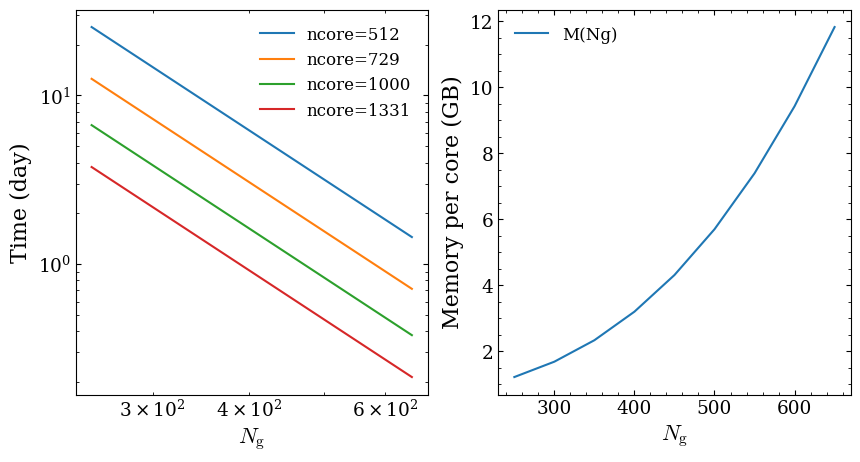

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ncore = np.arange(8, 12)**3
Ng = np.arange(250, 700, 50)
for n in ncore:
    ax[0].loglog(Ng, f_T(Ng, n)/24, label=f'ncore={n}')
ax[0].set_ylabel('Time (day)')
ax[0].set_xlabel('$N_\\mathrm{{g}}$')
ax[0].legend()

ax[1].plot(Ng, f_M(Ng), label='M(Ng)')
ax[1].set_ylabel('Memory per core (GB)')
ax[1].set_xlabel('$N_\\mathrm{{g}}$')

ax[1].legend()
plt.show()

# A Non-Linear Programming problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')
from numba import njit

@njit
def f_M(Ng):
    return 5.12 * (Ng/500)**3 + 0.58
    #return 5.12 * (Ng/500)**3 + 0.58

@njit
def f_T(Ng, ncore, Ntot=10**4):
    return 20 * (500/Ng)**3 * (1000/ncore)**2 * (Ntot / 10000)**6

@njit
def f_Ng(M):
    return 500 * ((M - 0.58)/5.12)**(1/3)

def plan(total_memory, max_ncores, min_Ntot, max_walltime):
    """
    Given the total memory, the maximum number of cores, 
    and the target total resolution we want, gives a setting that
    minimized the core-time.
    """
    max_ncores_cbrt = int(np.cbrt(max_ncores))
    min_core_time = 1e20
    results = []
    for Ntot in range(min_Ntot, int(1.5*min_Ntot), 1):
        for ncores_cbrt in range(1, max_ncores_cbrt+1):
            max_memory_per_core = total_memory // max_ncores
            max_Ng = round(f_Ng(max_memory_per_core))
            for Ng in range(250, max_Ng+1):
                nloops_cbrt = Ntot / ncores_cbrt / Ng
                if nloops_cbrt.is_integer():
                    # print(Ng, ncores_cbrt**3, Ntot)
                    T = f_T(Ng, ncores_cbrt**3, Ntot) 
                    nT = T * ncores_cbrt**3
                    M = f_M(Ng)
                    if M < max_memory_per_core:
                        if nT < min_core_time and T < max_walltime:
                            min_core_time = nT
                            best_set = (Ntot, ncores_cbrt**3, Ng, nloops_cbrt**3, nT, M)
                        results.append((Ntot, ncores_cbrt**3, Ng, nloops_cbrt**3, nT, M))
                else:
                    continue

    print(f"Total resolution: {best_set[0]}")
    print(f"Number of cores: {best_set[1]}")
    print(f"Resolution of each subbox: {best_set[2]}")
    print(f"Number of loops: {best_set[3]}")
    print(f"Core hour: {best_set[4]:.2f} core hours")
    print(f"Walltime: {best_set[4]/best_set[1]:.2f} hours")
    print(f"Memory per core: {best_set[5]:.2f} GB")
    return best_set#, results

def plan_extreme(total_memory, max_ncores, max_walltime, min_Ntot, max_Ntot):
    """
    Given the total memory, maximum number of cores, maximum total resolution
    (for a search range) and maximum walltime, gives the best setting that 
    maximizes the total resolution.
    """
    max_ncores_cbrt = int(np.cbrt(max_ncores))
    results = []
    for Ntot in range(min_Ntot, max_Ntot):
        for ncores_cbrt in range(1, max_ncores_cbrt+1):
            max_memory_per_core = total_memory // max_ncores
            max_Ng = round(f_Ng(max_memory_per_core))
            for Ng in range(250, max_Ng+1):
                nloops_cbrt = Ntot / ncores_cbrt / Ng
                if nloops_cbrt.is_integer():
                    # print(Ng, ncores_cbrt**3, Ntot)
                    T = f_T(Ng, ncores_cbrt**3, Ntot) 
                    nT = T * ncores_cbrt**3
                    M = f_M(Ng)
                    if M < max_memory_per_core:
                        if T < max_walltime:
                            best_set = (Ntot, ncores_cbrt**3, Ng, nloops_cbrt**3, nT, M)
                        results.append((Ntot, ncores_cbrt**3, Ng, nloops_cbrt**3, nT, M))
                else:
                    continue

    print(f"Total resolution: {best_set[0]}")
    print(f"Number of cores: {best_set[1]}")
    print(f"Resolution of each subbox: {best_set[2]}")
    print(f"Number of loops: {best_set[3]}")
    print(f"Core hour: {best_set[4]:.2f} core hours")
    print(f"Walltime: {best_set[4]/best_set[1]:.2f} hours")
    print(f"Memory per core: {best_set[5]:.2f} GB")
    return best_set

#@njit(fastmath=True)
def plan_per_core_mem(max_memory_per_core, max_ncores, min_Ntot, max_walltime):
    """
    Given the maximum memory per core, the maximum number of cores, 
    and the target total resolution we want, gives a setting that
    minimized the core-time.
    """
    # max_memory in GB
    # max_time in hours
    total_memory = max_memory_per_core * max_ncores
    best_set = plan(total_memory, max_ncores, min_Ntot, max_walltime)
    return best_set #, results

|                        | RM       | RM-shared | RM-512   | EM        |
| ---------------------- | -------- | --------- | -------- | --------- |
| Node RAM           | 256GB    | 256GB     | 512GB    | 4TB       |
| Node count default | 1        | NA        | 1        | NA        |
| Node count max     | 64       | NA        | 2        | 1         |
| Core count min     | 128      | 1         | 128      | 24        |
| $*$*Core count max*     | 6400     | 64        | 256      | 96        |
| $*$*RAM per core*           | 2GB      | 2GB       | 4GB      | 42.66GB   |
| Walltime default   | 1 hour   | 1 hour    | 1 hour   | 1 hour    |
| $*$*Walltime max*       | 72 hours | 72 hours  | 72 hours | 120 hours |


### 1. RM partition

In [43]:
# RM partition, more cores, small memory
plan_extreme(total_memory=2*6400, max_ncores=6400, max_walltime=72, 
             min_Ntot=10**4, max_Ntot=10**5) 

Total resolution: 17604
Number of cores: 5832
Resolution of each subbox: 326
Number of loops: 27.0
Core hour: 368245.84 core hours
Walltime: 63.14 hours
Memory per core: 2.00 GB


(17604, 5832, 326, 27.0, 368245.84262832, 1.9990991769600002)

In [21]:
plan(total_memory=2*6400, max_ncores=6400, min_Ntot=10000, max_walltime=72)

Total resolution: 10008
Number of cores: 5832
Resolution of each subbox: 278
Number of loops: 8.0
Core hour: 20048.04 core hours
Walltime: 3.44 hours
Memory per core: 1.46 GB


(10008, 5832, 278, 8.0, 20048.038410239995, 1.4600236339200003)

### 2. RM-512 partion

In [34]:
# RM-512 partition
plan_extreme(total_memory=4*256, max_ncores=256, max_walltime=72, 
             min_Ntot=10**3, max_Ntot=10**4)

Total resolution: 6120
Number of cores: 216
Resolution of each subbox: 340
Number of loops: 27.0
Core hour: 15472.41 core hours
Walltime: 71.63 hours
Memory per core: 2.19 GB


(6120, 216, 340, 27.0, 15472.412640000004, 2.1898918400000005)

## 3. EM partition

In [36]:
# EM partition!
plan_extreme(total_memory=4096, max_ncores=96, max_walltime=120, 
             min_Ntot=10**3, max_Ntot=10**4)

Total resolution: 7264
Number of cores: 64
Resolution of each subbox: 908
Number of loops: 8.0
Core hour: 7665.80 core hours
Walltime: 119.78 hours
Memory per core: 31.24 GB


(7264, 64, 908, 8.0, 7665.800314880001, 31.243201259520006)

## For test runs

In [38]:
# RM partition, more cores, small memory
plan_extreme(total_memory=2*64, max_ncores=64, max_walltime=72, 
             min_Ntot=10**1, max_Ntot=10**3) 

Total resolution: 978
Number of cores: 27
Resolution of each subbox: 326
Number of loops: 1.0
Core hour: 2.34 core hours
Walltime: 0.09 hours
Memory per core: 2.00 GB


(978, 27, 326, 1.0, 2.33860338, 1.9990991769600002)